# MLR in cryptocurrency pricing analysis: Final report

---

In [1]:
library(broom)
install.packages("latex2exp")
library(latex2exp)
library(tidyverse)
library(repr)
library(digest)
library(gridExtra)
#install.packages("scatterplot3d") # Install
#library("scatterplot3d") # load
library(gridExtra)
library(leaps)
library(GGally)
library(car)
library(mltools)
library(glmnet)
library(dplyr)

options(warn = -1)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package

![alt text](https://ethereum.org/static/28214bb68eb5445dcb063a72535bc90c/f3583/hero.png)

## Introduction
----

### Background
Cryptocurrency is a decentralized "purely peer-to-peer version of electronic cash" (Nakamoto, 2009). ETH (Ether) is one of the native cryptocurrencies designed for the Ethereum platform (Buterin, n.d.). As the second cryptocurrency only to Bitcoin in market capitalization, ETH has a tenfold price increase in one year since November, 2020 ([Yahoo finance](https://finance.yahoo.com/quote/ETH-USD/)). The surging value of cryptocurrencies raises studies with computational tools for price prediction.
### Purpose
This study will apply MLR and assessment / selection methods on the ETH dataset, aiming to build an optimized model that explains the linearity between the rate of change (ROC) of same-day inputs and the next-day return rate.
### Dataset

In [2]:
eth_raw <- read_csv('https://raw.githubusercontent.com/gzzen/stat-301-group-project/main/eth_dataset.csv') %>% na.omit()
head(eth_raw, 2)
tail(eth_raw, 2)

Rows: 493 Columns: 47

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (46): reddit_index, block_size, mining_difficulty, ethe_open_interest, ...
date  (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



date,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-24,2004.993,38301.08,2.405277e+15,1702398,566754,5530577,0.0202,3723607,13.4,⋯,0,0,141651691,137850993,3.5046,6450,1.916233e+14,1042273,108818350,0.086374
2020-06-25,2035.980,35299.83,2.406899e+15,1702281,584713,2795780,0.0197,3632507,13.4,⋯,0,0,128435656,115084909,3.0171,6448,1.915031e+14,1017408,108831273,0.101543


date,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-10-28,254.6987,64129.10,1.006534e+16,3128001,826217,2972658,0.0858,63507365,13.6,⋯,180195352,152798432,4755173026,4677848018,-0.0289822,6368,7.842797e+14,1456333,115181507,0.455180
2021-10-29,264.5458,62412.12,1.023876e+16,3128001,765907,1313643,0.0835,65172687,13.6,⋯,102822580,41716992,2839980504,2612652448,-0.0289822,6345,7.986090e+14,1379095,115194221,0.391936


The raw data is pulled from [qkl123](https://www.qkl123.com/project/eth/data) that consists a comprehensive collection of featured indicators for ETH. The semi-finished dataset `eth_data` is then hand-crafted by merging columns with Python ([detailed process](https://github.com/gzzen/stat-301-group-project/blob/main/proposal/dataset/merge_dataset.ipynb)). Below we roughly peek at columns of the data. 

In [3]:
cat('Total number of columns: ', ncol(eth_raw))
colnames(eth_raw)

Total number of columns:  47

[1] "date"                        "reddit_index"               
 [3] "block_size"                  "mining_difficulty"          
 [5] "ethe_open_interest"          "activate_address"           
 [7] "on_chain_transaction_vol"    "unit_computing_income"      
 [9] "daily_block_reward"          "block_gen_rate"             
[11] "price"                       "open_interest_top100"       
[13] "open_interest_top50"         "open_interest_top30"        
[15] "open_interest_top10"         "avg_gas_cost"               
[17] "unit_transaction_fee"        "mining_vol"                 
[19] "margin_call_s"               "margin_call_m"              
[21] "margin_call_l"               "margin_call_x"              
[23] "short_margin_call"           "long_margin_call"           
[25] "new_addresses"               "open_interest"              
[27] "business_vol"                "interest"                   
[29] "basis"                       "inflow_maker"               
[31] "outflow_maker"               "inflow_retail"              
[33] "outflow_retail"              "net"                        
[35] "daily_uncle_block_reward"    "trade_vol_s"                
[37] "trade_vol_m"                 "trade_vol_l"                
[39] "trade_vol_x"                 "short"                      
[41] "long"                        "ethe_otc_premium"           
[43] "block_count"                 "avg_computing_power"        
[45] "transaction_vol"             "supply"                     
[47] "reddit_follower_growth_rate"

The composition of dataset includes 47 columns spreading across 5 categories:
- `price` and `date` are the most basic figures in trading.
- `block_size`, `mining_difficulty`, etc. consists information of the blockchain.
- `business_vol`, `outflow_retail`, etc. are indicators in the spot market.
- `long_margin_call`, `margin_call_l`, etc. are indicators in the future market.
- `reddit_index`, `ethe_otc_premium`, etc. have no specific attributes, but are interesting to consider.

And we will further explain some of the variables after we reduce redundancy in the dataset.

## Method
---
### Cleaning and wrangling
- To reliminate the cumulative effects of pricing and other factors, we need to change the raw numeric figures to ROC (rate of change). 
- The formula of ROC given by:
$$
ROC = \frac{V_{final} - V_{initial}}{V_{initial}}\\
$$

- Therefore, we would first eleminate the non-numeric variable `date`.

In [4]:
eth_selected <- eth_raw %>% select(-date)

eth_shift1 <- eth_selected %>% head(nrow(eth_raw) - 1)
eth_shift1 <- rbind(rep(0, ncol(eth_shift1)), eth_shift1)
head(eth_shift1)
head(eth_selected)

nrow(eth_shift1)

eth <- ((eth_selected - eth_shift1) / eth_selected) %>% tail(nrow(eth_selected) - 1)

head(eth, 2)
tail(eth, 2)

reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000,0.00,0.000000e+00,0,0,0,0.0000,0,0.0,0.0000,⋯,0,0,0,0,0.0000,0,0.000000e+00,0,0,0.000000
2004.993,38301.08,2.405277e+15,1702398,566754,5530577,0.0202,3723607,13.4,233.0257,⋯,0,0,141651691,137850993,3.5046,6450,1.916233e+14,1042273,108818350,0.086374
2035.980,35299.83,2.406899e+15,1702281,584713,2795780,0.0197,3632507,13.4,229.5401,⋯,0,0,128435656,115084909,3.0171,6448,1.915031e+14,1017408,108831273,0.101543
2056.894,36471.11,2.387370e+15,1702281,554079,1809875,0.0194,3507628,13.6,227.2679,⋯,0,0,78961382,73166365,3.0171,6365,1.877355e+14,1017192,108844030,0.104361
2078.532,33620.33,2.341417e+15,1702281,587223,1336871,0.0192,3424360,13.2,224.9650,⋯,0,0,168139112,168172008,3.0171,6522,1.880458e+14,997942,108857101,0.107589
2088.733,34826.14,2.397435e+15,1701932,635711,1559098,0.0193,3492081,13.5,223.9209,⋯,0,0,114574412,107306852,2.9924,6393,1.899869e+14,1056443,108869915,0.093134


reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004.993,38301.08,2.405277e+15,1702398,566754,5530577,0.0202,3723607,13.4,233.0257,⋯,0,0,141651691,137850993,3.5046,6450,1.916233e+14,1042273,108818350,0.086374
2035.980,35299.83,2.406899e+15,1702281,584713,2795780,0.0197,3632507,13.4,229.5401,⋯,0,0,128435656,115084909,3.0171,6448,1.915031e+14,1017408,108831273,0.101543
2056.894,36471.11,2.387370e+15,1702281,554079,1809875,0.0194,3507628,13.6,227.2679,⋯,0,0,78961382,73166365,3.0171,6365,1.877355e+14,1017192,108844030,0.104361
2078.532,33620.33,2.341417e+15,1702281,587223,1336871,0.0192,3424360,13.2,224.9650,⋯,0,0,168139112,168172008,3.0171,6522,1.880458e+14,997942,108857101,0.107589
2088.733,34826.14,2.397435e+15,1701932,635711,1559098,0.0193,3492081,13.5,223.9209,⋯,0,0,114574412,107306852,2.9924,6393,1.899869e+14,1056443,108869915,0.093134
2068.726,34530.46,2.358195e+15,1701815,614460,1991476,0.0208,3787010,13.3,226.1556,⋯,0,0,118371376,123463154,3.5626,6479,1.892040e+14,1112487,108882902,0.118147


[1] 484

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.01521965,-0.08502187,0.0006735777,-6.850295e-05,0.03071421,-0.9781877,-0.02538071,-0.02507922,0.00000000,-0.015185498,⋯,NaN,NaN,-0.1029001,-0.1978199,-0.161579,-0.0003101737,-0.0006277275,-0.0244395562,0.0001187429,0.14938499
3,0.01016766,0.03211535,-0.0081798461,0.000000e+00,-0.05528814,-0.5447362,-0.01546392,-0.03560211,0.01470588,-0.009997672,⋯,NaN,NaN,-0.6265629,-0.5729210,0.000000,-0.0130400628,-0.0200686305,-0.0002123493,0.0001172044,0.02700242


,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_l,trade_vol_x,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
483,-0.06876724,-0.05134246,0.006142519,-6.841729e-05,0.01639642,0.3928916,0.03263403,0.05870187,0.007352941,0.06530376,⋯,0.0933847,0.4188637,0.1735170,0.1826353,0.2905577,-0.006281407,0.002719107,-0.03719548,0.0001107708,0.1868931
484,0.03722240,-0.02751028,0.016937343,0.000000e+00,-0.07874324,-1.2629118,-0.02754491,0.02555245,0.000000000,-0.03772092,⋯,-0.7524881,-2.6627385,-0.6743682,-0.7904594,0.0000000,-0.003624901,0.017942844,-0.05600629,0.0001103755,-0.1613631


Observe that there are many `NaN`s and infinity values in the ROC form of our dataset. One approach to encounter this problem is to use `na.omit()`. However, when we apply this method to the whole dataframe, only few valid rows are left.

In [5]:
cat('Number of rows left after removing invalid values:', na.omit(eth) %>% nrow())

Number of rows left after removing invalid values: 16

So we have to remove variables that constribute the most invalid values. A much more comprehensive dataset is produced after these columns are excluded, which is helpful for our further analysis.

In [6]:
eth <- eth %>% 
    select(-trade_vol_l, -trade_vol_x, -margin_call_l, -margin_call_x) %>%
    na.omit()

head(eth, 2)
tail(eth, 2)
cat('Number of rows left after removing invalid values:', eth %>% nrow())

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_s,trade_vol_m,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.01521965,-0.08502187,0.0006735777,-6.850295e-05,0.03071421,-0.9781877,-0.02538071,-0.02507922,0.00000000,-0.015185498,⋯,-0.1482535,-0.1342297,-0.1029001,-0.1978199,-0.161579,-0.0003101737,-0.0006277275,-0.0244395562,0.0001187429,0.14938499
3,0.01016766,0.03211535,-0.0081798461,0.000000e+00,-0.05528814,-0.5447362,-0.01546392,-0.03560211,0.01470588,-0.009997672,⋯,-0.5679118,-2.7410958,-0.6265629,-0.5729210,0.000000,-0.0130400628,-0.0200686305,-0.0002123493,0.0001172044,0.02700242


,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_s,trade_vol_m,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
483,-0.06876724,-0.05134246,0.006142519,-6.841729e-05,0.01639642,0.3928916,0.03263403,0.05870187,0.007352941,0.06530376,⋯,0.2300769,0.1415145,0.1735170,0.1826353,0.2905577,-0.006281407,0.002719107,-0.03719548,0.0001107708,0.1868931
484,0.03722240,-0.02751028,0.016937343,0.000000e+00,-0.07874324,-1.2629118,-0.02754491,0.02555245,0.000000000,-0.03772092,⋯,-0.7454120,-0.6954366,-0.6743682,-0.7904594,0.0000000,-0.003624901,0.017942844,-0.05600629,0.0001103755,-0.1613631


Number of rows left after removing invalid values: 432

Next, we can derive our target response: **return rate of the next day**, by moving our `price` column one unit upward. THis gives our new column `TARGET_return_nextday`.

In [7]:
# switch the next-day price as the response variable of the same-day variables
price_temp = pull(eth, price)

# we delete the first row of target because we don't have the explanatory variables from previous day
TARGET_return_nextday <- price_temp[-1]

# we delete the last row because we don't have the actual target variable of the latest day, we'll have to wait till monday!
eth_data <- eth[-length(price_temp),]

In [8]:
# merge the operation with original dataset
eth_data <- cbind(eth_data, TARGET_return_nextday)

In [9]:
cat('Number of inputs:', ncol(eth_data) - 1)

Number of inputs: 42

We now have:  
- `TARGET_return_nextday` as our **response variable**, and 45 variables as inputs to choose from.

## Method
---

### Association between explanotory variables and response
To assure the viability of this model, we want to check that the collected data of the previous day are indeed associated with our targeted response, to do that, we first use`cor()` to test the correlation between our explanotory variables and response.
> Also notice: right now `TARGET_return_nextday` is also in the correlation chart, we need to get rid of that since it's the response we're looking for.

In [10]:
# create correlation chart 
eth_target_cor_chart <- data.frame(cor(eth_data[-1])) %>%
    select(TARGET_return_nextday)

# order the rows by correlation
colnames(eth_target_cor_chart) <- c('correlation')
head(eth_target_cor_chart)
correlation_data <- 
    eth_target_cor_chart %>% 
    arrange(desc(correlation)) %>% 
    filter(correlation != 1)


head(correlation_data, 3)
tail(correlation_data, 3)

,correlation
,<dbl>
block_size,0.009426553
mining_difficulty,0.020474357
ethe_open_interest,0.027616354
activate_address,0.089193471
on_chain_transaction_vol,0.064301913
unit_computing_income,0.107016304


,correlation
,<dbl>
daily_uncle_block_reward,0.1095453
daily_block_reward,0.1087825
unit_computing_income,0.1070163


,correlation
,<dbl>
short_margin_call,-0.05742979
margin_call_s,-0.07857461
long_margin_call,-0.08473308


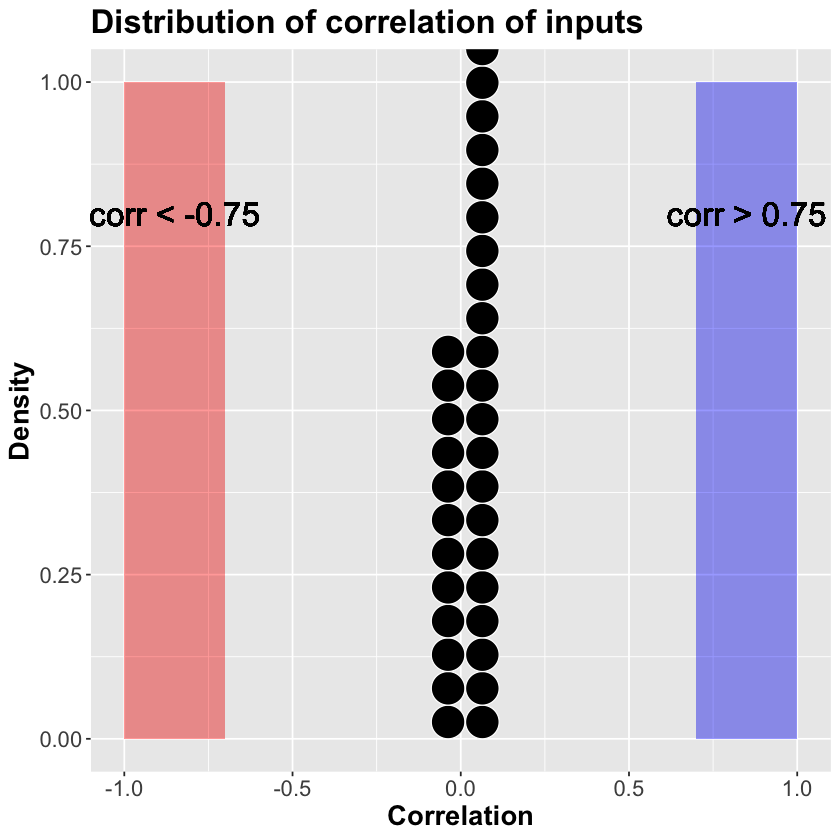

In [11]:
# visualize correlation of inputs with the next-day price
eth_cor_histogram <- 
    correlation_data %>%
    ggplot(aes(x=correlation)) +
    geom_dotplot(binwidth=1/10, color='white')  +
    geom_rect(aes(xmin=-1, xmax=-0.7, ymin=0, ymax=1), fill='red', alpha=0.01) +
    geom_rect(aes(xmin=0.7, xmax=1, ymin=0, ymax=1), fill='blue', alpha=0.01) +
    geom_text(x=-0.85, y=0.8, label='corr < -0.75', size=7) +
    geom_text(x=0.85, y=0.8, label='corr > 0.75', size=7) +
    labs(x='Correlation', y='Density', title='Distribution of correlation of inputs') +
    theme(
        text = element_text(size = 16.5),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold"))

eth_cor_histogram

Although there's no absolute standard, a correlation $corr>0.75$ or $corr<-0.75$ is usually considered strong. Unfortunately most of our input variables has low correlation level with the response. 
> Consider the price prediction for cryptocurrency being a million-dollar project, nice-and-easy predictors that are strongly correlated to the change in price would have never existed. 

`geom_smooth()` using formula 'y ~ x'



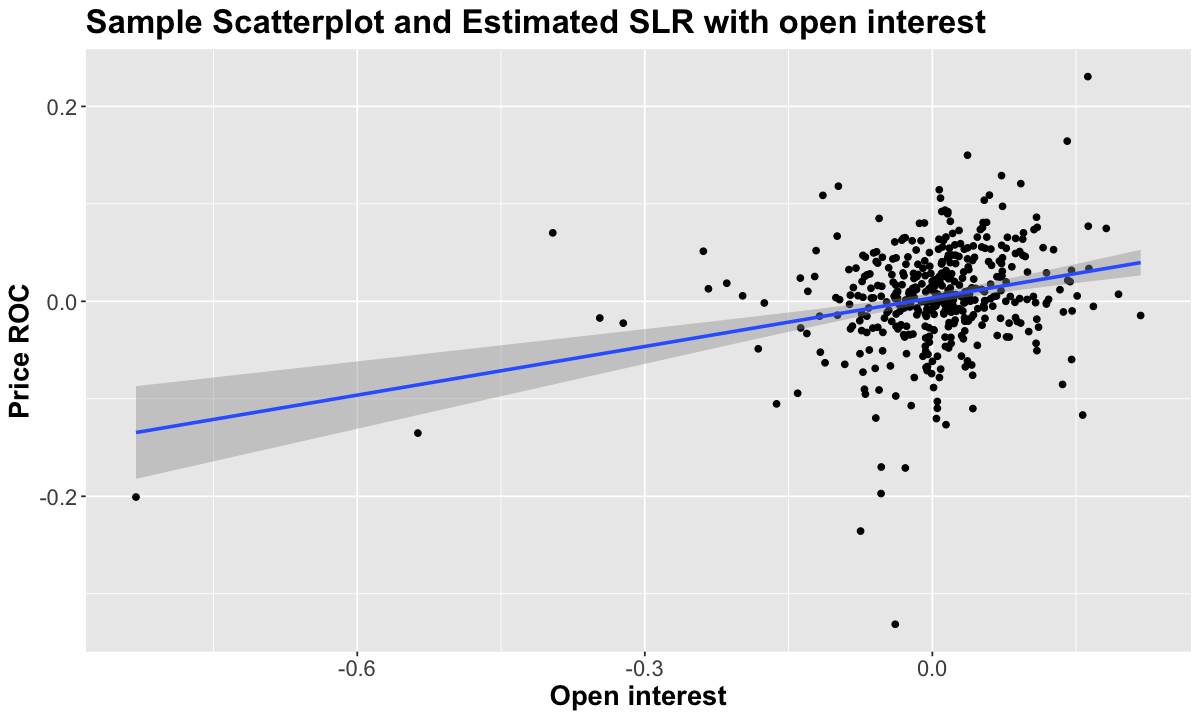

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6)

eth_sample_plot<- eth_data %>%
    ggplot(aes(x = open_interest, y = price))+
    geom_point()+
    geom_smooth(aes(x = open_interest, y = price),method = "lm")+
    xlab("Open interest") +
    ylab("Price ROC") +
    ggtitle("Sample Scatterplot and Estimated SLR with open interest") +
    theme(
        text = element_text(size = 16.5),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

eth_sample_plot

Our plot seems promising already with only one variable. However, notice that as we're targeting at price here, we'd want our prediction to have a relatively small confidence interval so that it wouldn't contain previous day's price too often (in that case our prediction of ETH's gain/loss rate would be inconclusive). That's why we still need to put more variables into consider when conducting the model.

Below we include `business_vol` in addition to `open_interest` to construct a two-variable MLR model, as to check how that fits in a 3-dimension coordinate.

In [13]:
# MLR model
MLR_add_sample <- lm(price~business_vol+open_interest, data=eth_data)

tidy(MLR_add_sample, conf.int=TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,0.00,0.77,0.44,0.00,0.01
business_vol,-0.03,0.01,-4.03,0.00,-0.04,-0.01
open_interest,0.18,0.03,6.38,0.00,0.13,0.24


In [14]:
# scatterplot
# s3d <- scatterplot3d(x=eth_data$business_vol, y=eth_data$open_interest, z=eth_data$price, pch=19, type="p", color="black",
#                      main="Sample 2-variable MLR addictive model", grid = TRUE, box = FALSE,  
#                      mar = c(2.5, 2.5, 2, 1.5), angle = 55, xlab='Business volume', ylab='Open interest', zlab='Price ROC')

# s3d$plane3d(MLR_add_sample, draw_polygon = TRUE, draw_lines = TRUE, polygon_args = list(col = rgb(0.8,0.8,0.8,0.8)))

Note that most observations lies under the regression plane. The inequal distribution of scatters possibly implies a non-linear association. Therefore, the MLR model we just constructed could be one approach of estimation, but may not be the best fit of our dataset. 

### A. Model Building  
    1. Full Addition Model  
    2. Full Interaction Model  
    3. Model using Backward Selection  
    4. Model using Forward Selection  
    5. Model using LASOO Selection  
    6. Find the best models given by each selection method.


In [15]:
nrow_before <- nrow(eth_data)
cat("current eth_data has #", nrow_before, "rows of data with NA")
eth_data <- eth_data%>%na.omit(eth_data)
eth_data <- eth_data[is.finite(rowSums(eth_data)),]
nrow_after <- nrow(eth_data)
cat("Now eth_data has #", nrow_after, "rows of datawithout NA")

current eth_data has # 431 rows of data with NANow eth_data has # 386 rows of datawithout NA

In [16]:
set.seed(2022)

In [17]:
eth_data$ID <- 1:nrow(eth_data)

training_eth <- sample_n(eth_data, size = nrow(eth_data) * 0.75,
  replace = FALSE
)

testing_eth <- anti_join(eth_data,
  training_eth,
  by = "ID"
)

head(training_eth,1)
ncol(training_eth)
head(testing_eth,1)
ncol(testing_eth)
training_eth <- training_eth[,-44]
testing_eth <- testing_eth[,-44]

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate,TARGET_return_nextday,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.006696704,-0.04477026,-0.01188615,-6.847448e-05,0.008491456,-0.3226862,-0.02727273,-0.1052808,0,0.01453557,⋯,-0.5256172,-0.5548008,9.638668,0.002147898,-0.007848086,-0.01201486,0.0001156277,0.3664589,0.06970112,228


[1] 44

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate,TARGET_return_nextday,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.01016766,0.03211535,-0.008179846,0,-0.05528814,-0.5447362,-0.01546392,-0.03560211,0.01470588,-0.009997672,⋯,-0.6265629,-0.572921,0,-0.01304006,-0.02006863,-0.0002123493,0.0001172044,0.02700242,-0.01023666,2


[1] 44

In [18]:
#Full addition model
MLR_FAM <- lm(TARGET_return_nextday~., data=training_eth)
head(tidy(MLR_FAM, conf.int = TRUE))
nrow(tidy(MLR_FAM))

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.017378018,0.02658353,-0.65371363,0.5139069,-0.06973838,0.03498235
reddit_index,-0.196015493,0.14734548,-1.33031224,0.1846474,-0.48623513,0.09420414
block_size,-0.074827386,0.09224462,-0.81118433,0.4180440,-0.25651738,0.10686261
mining_difficulty,-0.130332441,1.85704367,-0.07018276,0.9441052,-3.78806626,3.52740137
ethe_open_interest,1.318779948,1.14363081,1.15315182,0.2499673,-0.93377725,3.57133714
activate_address,0.003105469,0.05408114,0.05742240,0.9542553,-0.10341567,0.10962661


[1] 43

In [19]:
#Forward Selection Model
eth_MLR_forward_sel <- regsubsets(
   x = TARGET_return_nextday~.,
   data = training_eth, 
    nvmax = 47, 
    method = "forward",
 )

fwd_summary <- summary(eth_MLR_forward_sel)

#fwd_summary
which.min(fwd_summary$cp )

[1] 6

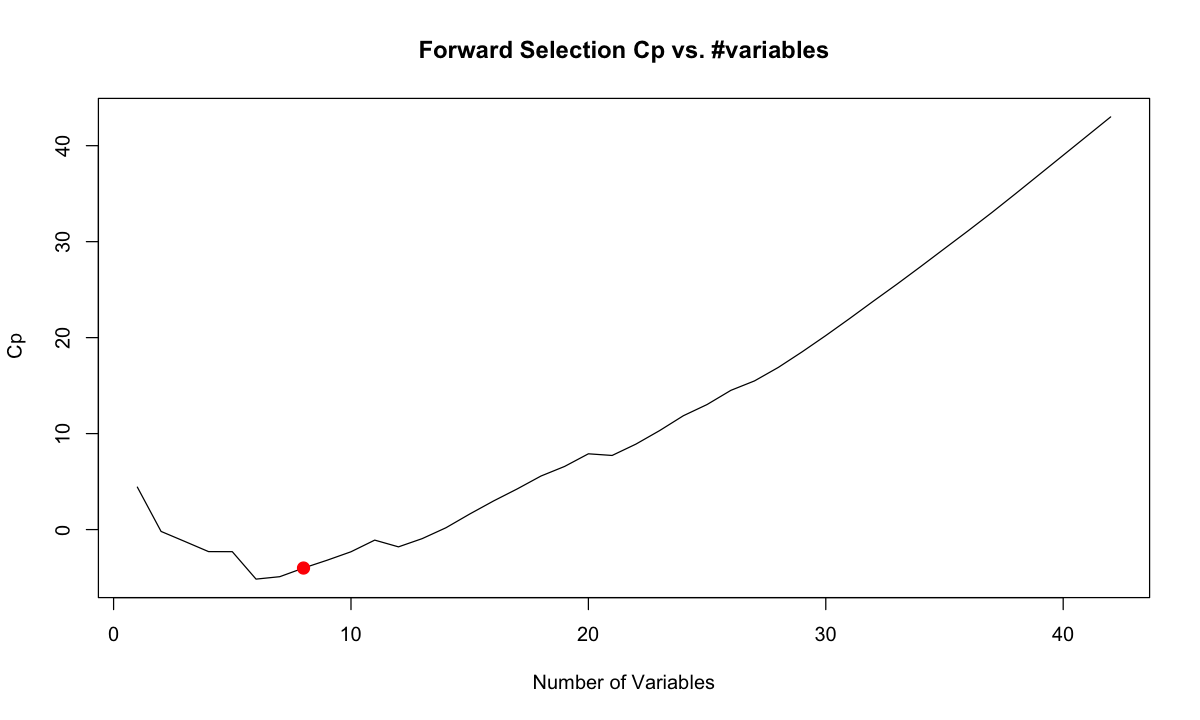

In [20]:
plot(
    fwd_summary$cp ,
    xlab =" Number of Variables ", 
    ylab =" Cp",
    type="l",
    main = "Forward Selection Cp vs. #variables")
points (8, fwd_summary$cp [8] , col ="red", cex =2, pch =20)

[1] 10

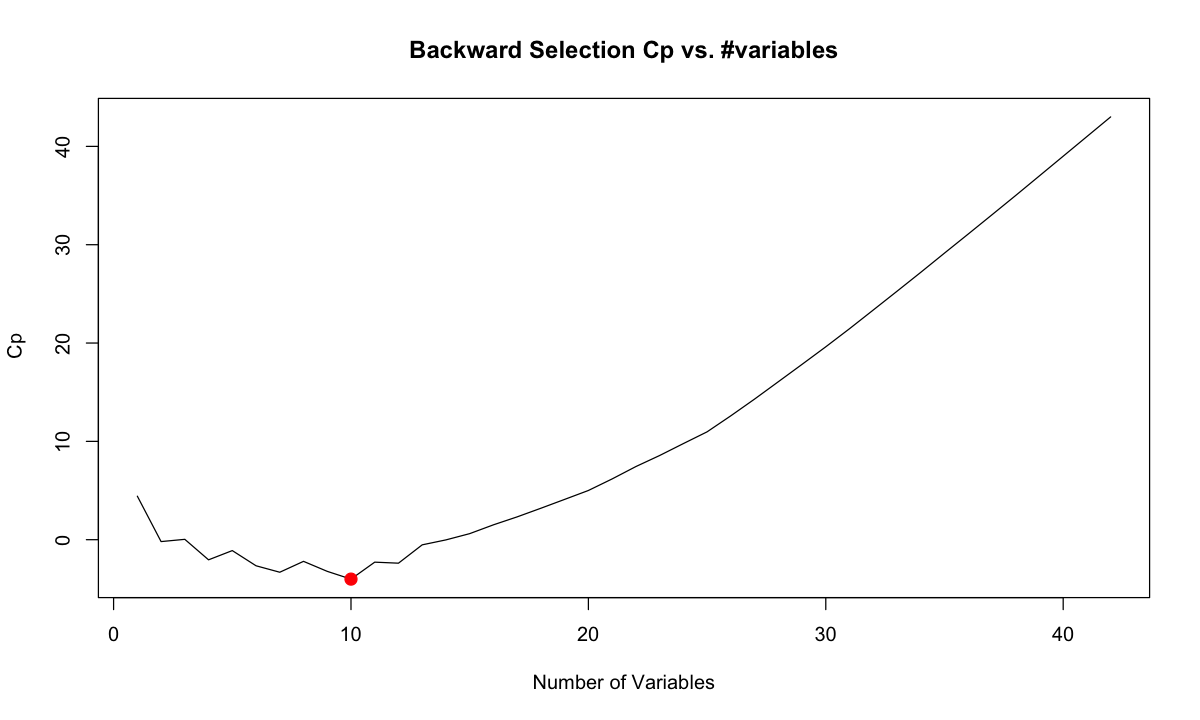

In [21]:
#Backward Selection
eth_MLR_backward_sel <- regsubsets(
   x = TARGET_return_nextday~.,
   data = training_eth, 
    nvmax = 49, 
    method = "backward",
 )

bwd_summary <- summary(eth_MLR_backward_sel)

plot(
    bwd_summary$cp ,
    xlab =" Number of Variables ", 
    ylab =" Cp",
    type="l",
    main = "Backward Selection Cp vs. #variables")
points (10, bwd_summary$cp [10] , col ="red", cex =2, pch =20)

which.min(bwd_summary$cp )

In [22]:
TARGET_return_nextday <- training_eth$TARGET_return_nextday

x_vars <- model.matrix(object = TARGET_return_nextday~.,
                      data = training_eth)

head(x_vars,1)



,(Intercept),reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,⋯,trade_vol_s,trade_vol_m,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate
1,1,-0.006696704,-0.04477026,-0.01188615,-6.847448e-05,0.008491456,-0.3226862,-0.02727273,-0.1052808,0,⋯,-0.3995598,-0.631971,-0.5256172,-0.5548008,9.638668,0.002147898,-0.007848086,-0.01201486,0.0001156277,0.3664589


lambda,estimate,std.error,conf.low,conf.high,nzero
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.010792300,0.002804021,0.0005417290,0.002262292,0.003345750,0
0.009833541,0.002802362,0.0005409655,0.002261396,0.003343327,1
0.008959957,0.002802902,0.0005399503,0.002262952,0.003342852,1
0.008163979,0.002804739,0.0005388683,0.002265871,0.003343608,1
0.007438714,0.002806094,0.0005379692,0.002268125,0.003344063,2
0.006777879,0.002806074,0.0005366384,0.002269436,0.003342713,2


lambda,estimate,std.error,conf.low,conf.high,nzero
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3.617150e-06,0.003151669,0.0005203934,0.002631276,0.003672062,42
3.295812e-06,0.003152122,0.0005204558,0.002631666,0.003672578,42
3.003022e-06,0.003152557,0.0005205311,0.002632026,0.003673088,42
2.736241e-06,0.003152933,0.0005205956,0.002632337,0.003673528,42
2.493161e-06,0.003153295,0.0005206591,0.002632636,0.003673954,42
2.271676e-06,0.003153644,0.0005207222,0.002632922,0.003674366,42


[1] 92

[1] 0.010792300 0.009833541 0.008959957 0.008163979 0.007438714 0.006777879

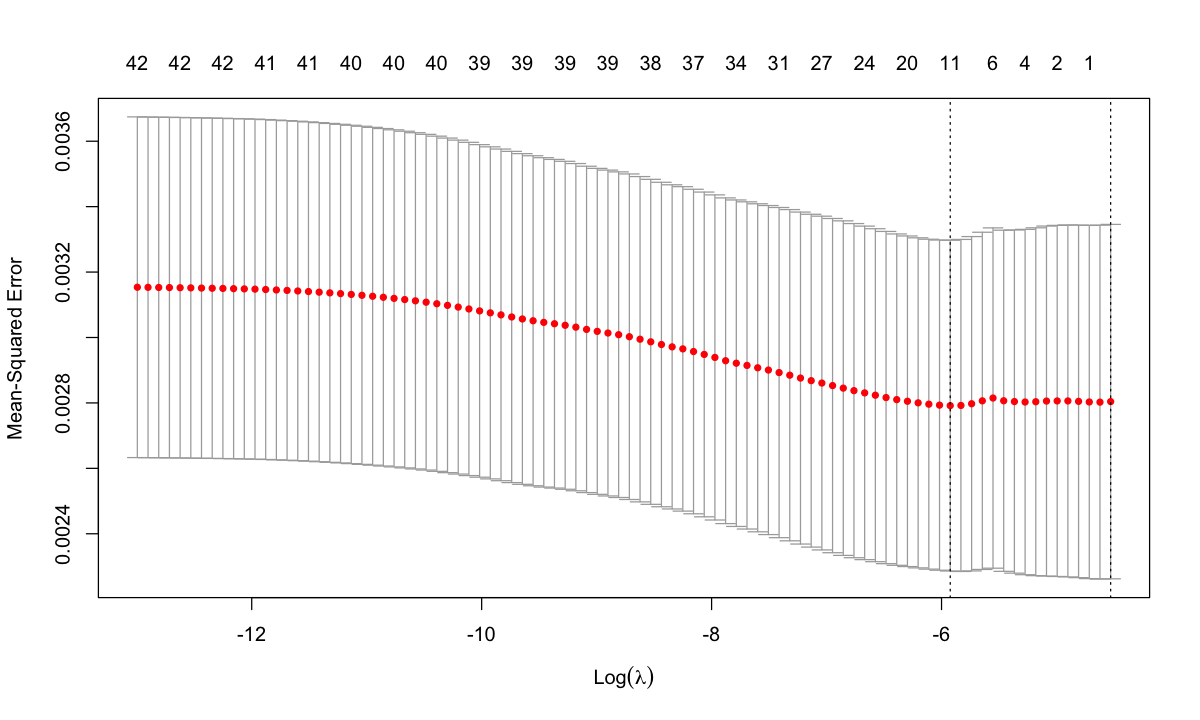

In [23]:
eth_cv_lambda_lasso <- cv.glmnet(
    x = x_vars,
    y = TARGET_return_nextday,
    alpha = 1,
)
head(tidy(eth_cv_lambda_lasso))
tail(tidy(eth_cv_lambda_lasso))
lambda_best <- eth_cv_lambda_lasso$lambda.min
which.min(eth_cv_lambda_lasso$lambda)
head(eth_cv_lambda_lasso$lambda)

plot(eth_cv_lambda_lasso)




In [24]:
lasso_model <- glmnet(x = x_vars,
                      y = TARGET_return_nextday,
                      alpha = 1, 
                      lambda = eth_cv_lambda_lasso$lambda.min)


tidy(lasso_model)
tidy(lasso_model)$term

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,1.819149e-03,0.002673335,0.07398015
ethe_open_interest,1,1.334223e-01,0.002673335,0.07398015
daily_block_reward,1,4.485148e-03,0.002673335,0.07398015
open_interest_top10,1,-1.922861e-01,0.002673335,0.07398015
margin_call_s,1,-7.577565e-04,0.002673335,0.07398015
margin_call_m,1,-8.071530e-04,0.002673335,0.07398015
short_margin_call,1,-2.575345e-04,0.002673335,0.07398015
open_interest,1,-2.447350e-03,0.002673335,0.07398015
interest,1,3.557670e-05,0.002673335,0.07398015


[1] "(Intercept)"              "ethe_open_interest"      
 [3] "daily_block_reward"       "open_interest_top10"     
 [5] "margin_call_s"            "margin_call_m"           
 [7] "short_margin_call"        "open_interest"           
 [9] "interest"                 "basis"                   
[11] "inflow_maker"             "daily_uncle_block_reward"

In [25]:
lasso_training_eth <- training_eth%>%
    select(
        unit_computing_income,
        daily_block_reward,
        price,
        open_interest_top100,
        open_interest_top10,
        avg_gas_cost,
        margin_call_m,
        short_margin_call,
        basis,
        inflow_maker,
        net,
        daily_uncle_block_reward,
        TARGET_return_nextday
          )

lasso_testing_eth <- testing_eth%>%
    select(
        unit_computing_income,
        daily_block_reward,
        price,
        open_interest_top100,
        open_interest_top10,
        avg_gas_cost,
        margin_call_m,
        short_margin_call,
        basis,
        inflow_maker,
        net,
        daily_uncle_block_reward,
        TARGET_return_nextday
          )
#predict(lasso_model, s =lambda_best, newx =  testing_eth[,-1])

lasso_model <- lm(TARGET_return_nextday~., lasso_training_eth)

In [26]:
predicted_with_lasso <- predict(lasso_model, testing_eth)
predicted_traget_comparison <- cbind(testing_eth, predicted_with_lasso)%>%
    select(TARGET_return_nextday,predicted_with_lasso)%>%
    filter(TARGET_return_nextday * predicted_with_lasso > 0
           | ( ((-0.01 <= TARGET_return_nextday) & (TARGET_return_nextday <= 0.01))
              & ((-0.01 <= predicted_with_lasso) & (predicted_with_lasso <= 0.01))) )

# length(predicted_with_lassso)
# nrow(predicted_traget_comparison)
lasso_correct_prediction_rate <- nrow(predicted_traget_comparison) / length(predicted_with_lasso)
cat("Fall Addition Model yields ", round(lasso_correct_prediction_rate, 2), "% of correctness in testing dataset")

Fall Addition Model yields  0.71 % of correctness in testing dataset

In [27]:
predicted_with_fam <- predict(MLR_FAM, testing_eth)
predicted_traget_comparison <- cbind(testing_eth, predicted_with_fam)%>%
    select(TARGET_return_nextday,predicted_with_fam)%>%
    filter(TARGET_return_nextday * predicted_with_fam > 0
           | ( ((-0.01 <= TARGET_return_nextday) & (TARGET_return_nextday <= 0.01))
              & ((-0.01 <= predicted_with_fam) & (predicted_with_fam <= 0.01))) )

# length(predicted_with_fam)
# nrow(predicted_traget_comparison)
fam_correct_prediction_rate <- nrow(predicted_traget_comparison) / length(predicted_with_fam)
cat("Fall Addition Model yields ", round(fam_correct_prediction_rate, 2), "% of correctness in testing dataset")

Fall Addition Model yields  0.57 % of correctness in testing dataset

In [28]:
#Forward Selction Generated Above
forward_model <- 
lm(TARGET_return_nextday~ on_chain_transaction_vol + 
daily_block_reward +
open_interest_top50 + 
open_interest_top10 +
unit_transaction_fee +
margin_call_m +
new_addresses +
daily_uncle_block_reward,
   testing_eth)

predicted_with_forwardSelection <- predict(forward_model, testing_eth)
predicted_forward_comparison <- cbind(testing_eth, predicted_with_forwardSelection)%>%
    select(TARGET_return_nextday,predicted_with_forwardSelection)%>%
    filter(TARGET_return_nextday * predicted_with_forwardSelection > 0
           | ( ((-0.01 <= TARGET_return_nextday) & (TARGET_return_nextday <= 0.01))
              & ((-0.01 <= predicted_with_forwardSelection) & (predicted_with_forwardSelection <= 0.01))) )

# length(predicted_with_forwardSelection)
# nrow(predicted_forward_comparison)
forward_correct_prediction_rate <- nrow(predicted_forward_comparison) / length(predicted_with_forwardSelection)
cat("Forward Selection yields ", round(forward_correct_prediction_rate, 2), "% of correctness in testing dataset")

Forward Selection yields  0.68 % of correctness in testing dataset

In [29]:
backward_model <- 
lm(TARGET_return_nextday~ 
   reddit_index+
    mining_difficulty+
    unit_computing_income+
    price+
    open_interest_top50+
    open_interest_top10+
    unit_transaction_fee+
    margin_call_s+
    inflow_maker+
    daily_uncle_block_reward+
    trade_vol_s,
   testing_eth)

In [30]:
predicted_with_backwardSelection <- predict(backward_model, testing_eth)
#cbind(testing_eth, predicted_with_backwardSelection)%>%select(TARGET_return_nextday, predicted_with_backwardSelection)
predicted_backward_comparison <- cbind(testing_eth, predicted_with_backwardSelection)%>%
    select(TARGET_return_nextday, predicted_with_backwardSelection)%>%
    filter(TARGET_return_nextday * predicted_with_backwardSelection > 0
          | ( ((-0.01 <= TARGET_return_nextday) & (TARGET_return_nextday <= 0.01))
              & ((-0.01 <= predicted_with_backwardSelection) & (predicted_with_backwardSelection <= 0.01))) )

# length(predicted_with_backwardSelection)
# nrow(predicted_backward_comparison)
forward_correct_prediction_rate <- nrow(predicted_backward_comparison) / length(predicted_with_backwardSelection)
cat("Backward Selection yields ", round(forward_correct_prediction_rate, 2), "% of correctness in testing dataset")

Backward Selection yields  0.67 % of correctness in testing dataset

We want to focus on our models' performance when dealing with a potential huge rate of change coming up, as that'd be crucial when actually trading crypto. We refactor the dataset and create a new factor column "roc_type" to indicate the level of change.

In [31]:
head(testing_eth)

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,trade_vol_m,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate,TARGET_return_nextday
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.010167661,0.03211535,-0.008179846,0.000000000,-0.055288145,-0.54473623,-0.015463918,-0.03560211,0.014705882,-0.009997672,⋯,-2.7410958,-0.62656290,-0.57292095,0.000000000,-0.013040063,-0.0200686305,-0.0002123493,0.0001172044,0.027002424,-0.0102366586
2,0.002297512,-0.12121735,0.010506917,0.000000000,0.403882405,-0.48868682,-0.058201058,-0.06422061,0.007462687,-0.002056642,⋯,-2.0209826,-0.52028534,-0.63135912,0.000000000,-0.007468492,0.0002137547,-0.0796915574,0.0001182304,-0.201464889,-0.0051329584
3,-0.028867264,0.02585218,0.032311162,0.001034724,-0.052901867,0.28599565,0.036697248,0.04150412,0.000000000,0.028341256,⋯,-0.1730751,0.06537562,0.13685442,-0.002588279,0.002151860,0.0325392587,0.0246565437,0.0001196272,-0.163779458,-0.0203898334
4,0.020266494,-0.01189714,-0.010437862,0.001559114,-0.001562767,-0.30622347,-0.009259259,0.00283238,0.007462687,-0.020389833,⋯,0.3009534,0.16845364,0.03253861,-0.141958367,-0.011819596,-0.0159265895,-0.0211297224,0.0001182409,-0.007273509,-0.0006587309
5,-0.012036656,0.02915672,-0.029270927,0.000000000,-0.124174300,-0.27080135,0.077500000,0.06107321,0.007518797,0.012352328,⋯,-0.5036349,-0.47056531,-0.51816468,0.000000000,-0.003841426,-0.0292898227,-0.0013434524,0.0001188932,0.141024809,0.0339513642
6,0.068152152,-0.03685981,0.017011858,0.000000000,-0.190577692,-0.03067242,0.036496350,0.11481746,0.007575758,-0.072628757,⋯,-0.4116203,-0.16432811,-0.19835466,0.000000000,-0.009935799,-0.0042676721,-0.0963873247,0.0001193827,-0.002298350,-0.0335940641


In [32]:
testing_eth_w_roctype <- testing_eth %>%
    mutate(roc_type = if_else(abs(TARGET_return_nextday) > 0.04, "Significant", "Insignificant"))

In [33]:
head(testing_eth_w_roctype)

nrow(testing_eth_w_roctype)

nrow(filter(testing_eth_w_roctype, roc_type == "Significant"))
testing_eth_significant <- filter(testing_eth_w_roctype, roc_type == "Significant")

,reddit_index,block_size,mining_difficulty,ethe_open_interest,activate_address,on_chain_transaction_vol,unit_computing_income,daily_block_reward,block_gen_rate,price,⋯,short,long,ethe_otc_premium,block_count,avg_computing_power,transaction_vol,supply,reddit_follower_growth_rate,TARGET_return_nextday,roc_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.010167661,0.03211535,-0.008179846,0.000000000,-0.055288145,-0.54473623,-0.015463918,-0.03560211,0.014705882,-0.009997672,⋯,-0.62656290,-0.57292095,0.000000000,-0.013040063,-0.0200686305,-0.0002123493,0.0001172044,0.027002424,-0.0102366586,Insignificant
2,0.002297512,-0.12121735,0.010506917,0.000000000,0.403882405,-0.48868682,-0.058201058,-0.06422061,0.007462687,-0.002056642,⋯,-0.52028534,-0.63135912,0.000000000,-0.007468492,0.0002137547,-0.0796915574,0.0001182304,-0.201464889,-0.0051329584,Insignificant
3,-0.028867264,0.02585218,0.032311162,0.001034724,-0.052901867,0.28599565,0.036697248,0.04150412,0.000000000,0.028341256,⋯,0.06537562,0.13685442,-0.002588279,0.002151860,0.0325392587,0.0246565437,0.0001196272,-0.163779458,-0.0203898334,Insignificant
4,0.020266494,-0.01189714,-0.010437862,0.001559114,-0.001562767,-0.30622347,-0.009259259,0.00283238,0.007462687,-0.020389833,⋯,0.16845364,0.03253861,-0.141958367,-0.011819596,-0.0159265895,-0.0211297224,0.0001182409,-0.007273509,-0.0006587309,Insignificant
5,-0.012036656,0.02915672,-0.029270927,0.000000000,-0.124174300,-0.27080135,0.077500000,0.06107321,0.007518797,0.012352328,⋯,-0.47056531,-0.51816468,0.000000000,-0.003841426,-0.0292898227,-0.0013434524,0.0001188932,0.141024809,0.0339513642,Insignificant
6,0.068152152,-0.03685981,0.017011858,0.000000000,-0.190577692,-0.03067242,0.036496350,0.11481746,0.007575758,-0.072628757,⋯,-0.16432811,-0.19835466,0.000000000,-0.009935799,-0.0042676721,-0.0963873247,0.0001193827,-0.002298350,-0.0335940641,Insignificant


[1] 97

[1] 34

In [34]:
predicted_with_backwardSelection <- predict(backward_model, testing_eth_significant)
predicted_backward_comparison <- cbind(testing_eth_significant, predicted_with_backwardSelection) %>%
    select(TARGET_return_nextday, predicted_with_backwardSelection)

head(predicted_backward_comparison)

nrow(predicted_backward_comparison)

correct_num_bigchange_backward <- nrow(filter(predicted_backward_comparison,
      abs(predicted_with_backwardSelection) > 0.04))

correct_num_bigchange_backward

,TARGET_return_nextday,predicted_with_backwardSelection
,<dbl>,<dbl>
1,0.04132265,0.0004253789
2,0.04155101,0.0120766789
3,-0.16996253,-0.0295185389
4,-0.04319785,-0.0035548917
5,0.11813881,0.0572020182
6,0.08105216,0.0009122071


[1] 34

[1] 7

In [35]:
predicted_with_forwardSelection_sig <- predict(forward_model, testing_eth_significant)
predicted_forward_comparison_sig <- cbind(testing_eth_significant, predicted_with_forwardSelection)%>%
    select(TARGET_return_nextday, predicted_with_forwardSelection)

head(predicted_forward_comparison)

nrow(predicted_forward_comparison)

correct_num_bigchange_forward <- nrow(filter(predicted_forward_comparison,
      abs(predicted_with_forwardSelection) > 0.015))

head(correct_num_bigchange_forward)

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 34, 97
